## Real Data ## 


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 28 10:58:27 2019

@author: shihao
"""

import sys
from obspy import *
import obspy.signal.array_analysis as AA
import matplotlib.pyplot as plt
import numpy as np
from obspy.signal.rotate import rotate2zne
import obspy.signal.util as util


paz_sts2 = {
    'poles': [-0.037004 + 0.037016j, -0.037004 - 0.037016j, -251.33 + 0j,
              - 131.04 - 467.29j, -131.04 + 467.29j],
    'zeros': [0j, 0j],
    'gain': 60077000.0,
    'sensitivity': 1500 * 419430.0}


array_stations = ['TW_NA01_2018*','TW_NA03*','TW_NA04*','TW_NA05*','TW_NA07*','TW_NA09*']
subarray = [0,1,2,3,4,5]

lon_total = [121.79333,121.79435,121.79228,121.79566,121.79267,121.79240]
lat_total = [24.46760,24.46720,24.46932,24.46687,24.46838,24.46670]

freq_low = 0.01
freq_high = 1
df = 20
t1 = 200
t2 = 1000

res = []
tsz = []
tsn = []
tse = []
coo = []
num = 0
first = True

# Read array data
for station in array_stations:
    stats = read(station)
    l_lon = lon_total[num]
    l_lat = lat_total[num]
    height = 0.
    num = num + 1
    
    stats.simulate(paz_remove=paz_sts2)

    stats.detrend("linear")     
    stats.taper(max_percentage=0.05,type='cosine')
    stats.filter("lowpass",freq=freq_high, corners=4, zerophase=True)
    stats.resample(sampling_rate=df)

 
    if first:
        first = False
        o_lon = l_lon
        o_lat = l_lat
        o_height = height

    lon,lat = util.util_geo_km(o_lon,o_lat,l_lon,l_lat)
    print(lon,lat)
    coo.append([lon*1000,lat*1000,height-o_height])
    
    tsz.append(stats.select(channel="HHZ")[0].data)
    tsn.append(stats.select(channel="HHN")[0].data)
    tse.append(stats.select(channel="HHE")[0].data)
    
    
ttse  =  np.array(tse)
ttsn  =  np.array(tsn)
ttsz  =  np.array(tsz)

subarray = np.array(subarray)
vp = 5000.
vs = 3560.
sigmau = 0.0000001








# rotation from array
result = AA.array_rotation_strain(subarray, np.transpose(ttse), np.transpose(ttsn), np.transpose(ttsz), vp, vs, np.array(coo), sigmau)

rotz = result['ts_w3']
rotn = result['ts_w2']
rote = result['ts_w1']

rots = stats.copy()
rots[0].stats.station = "ADR"
rots[0].stats.channel = "HJE"
rots[0].stats.location = "20"
rots[0].data = rote
rots[1].stats.station = "ADR"
rots[1].stats.channel = "HJN"
rots[1].stats.location = "20"
rots[1].data = rotn
rots[2].stats.station = "ADR"
rots[2].stats.channel = "HJZ"
rots[2].stats.location = "20"
rots[2].data = rotz
rots.detrend("linear")


# Read Blueseis data - Direct measurement
st_ro = read("TW_NA01_blueseis_20180206_1915.mseed", format="mseed")
st_ro[0].data  /= 1e9
st_ro[1].data /= 1e9
st_ro[2].data /= 1e9
st_ro.detrend("linear")
st_ro.taper(max_percentage=0.05,type='cosine')
st_ro.filter("lowpass",freq=freq_high, corners=4, zerophase=True)
st_ro.resample(sampling_rate=df)

0.0 0.0
0.10340917075375101 -0.04430624240075246
-0.10644973071344702 0.1905168423223541
0.2362192942092967 -0.08085889238083806
-0.06691150630869704 0.08639717268077471
-0.09428501728392553 -0.09968904540137823


3 Trace(s) in Stream:
XX.XBLU..HJE | 2018-02-06T19:15:19.999700Z - 2018-02-06T19:17:59.949700Z | 20.0 Hz, 3200 samples
XX.XBLU..HJN | 2018-02-06T19:15:19.999700Z - 2018-02-06T19:17:59.949700Z | 20.0 Hz, 3200 samples
XX.XBLU..HJZ | 2018-02-06T19:15:19.999700Z - 2018-02-06T19:17:59.949700Z | 20.0 Hz, 3200 samples

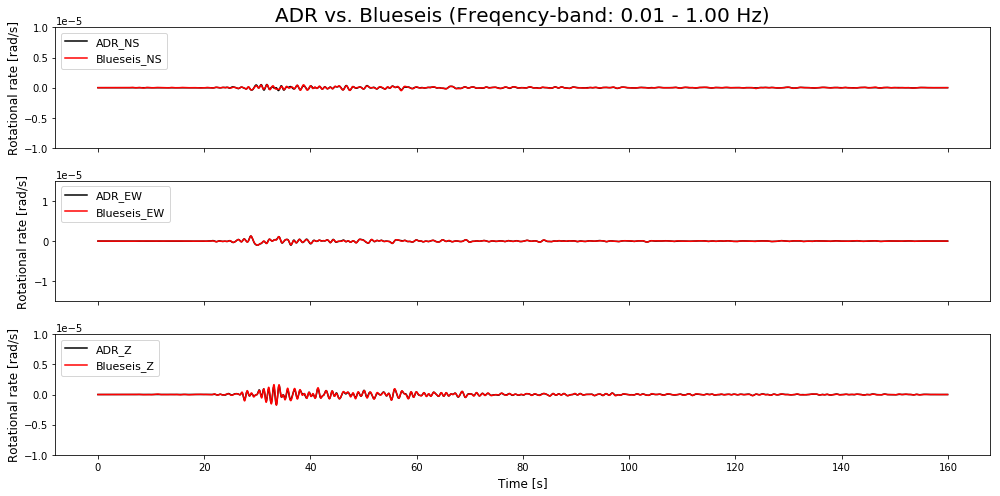

In [2]:
# Plot figures

plt.figure(figsize=(14,7))
ax1=plt.subplot(3, 1, 1)
plt.plot(rots[1].times(),rots[1].data,'k',label='ADR_NS')
plt.plot(rots[1].times(),st_ro.select(channel="HJN")[0].data,'r',label='Blueseis_NS')
#plt.xlim(300/df,1200/df)
plt.ylim(-1.e-5,1.e-5)
#plt.ylim(-2.e-6,2.e-6)
ax1.yaxis.major.formatter.set_powerlimits((-1,2))
plt.ylabel('Rotational rate [rad/s]',fontsize=12)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend(loc=2,prop={"size":11})
plt.title('ADR vs. Blueseis (Freqency-band: %1.2f - %1.2f Hz)'%(freq_low,freq_high),fontsize=20)

ax2=plt.subplot(312, sharex=ax1)
plt.plot(rots[0].times(),rots[0].data,'k',label='ADR_EW')
plt.plot(rots[0].times(),st_ro.select(channel="HJE")[0].data,'r',label='Blueseis_EW')
#plt.xlim(300/df,1200/df)
plt.ylim(-1.5e-5,1.5e-5)
#plt.ylim(-2.e-6,2.e-6)
ax2.yaxis.major.formatter.set_powerlimits((-1,2))
plt.ylabel('Rotational rate [rad/s]',fontsize=12)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.legend(loc=2,prop={"size":11})

ax3=plt.subplot(313,sharex=ax1, sharey=ax1)
plt.plot(rots[2].times(),rots[2].data,'k',label='ADR_Z')
plt.plot(rots[2].times(),st_ro.select(channel="HJZ")[0].data,'r',label='Blueseis_Z')
#plt.xlim(300/df,1200/df)
plt.ylim(-1.e-5,1.e-5)
#plt.ylim(-2.e-6,2.e-6)
ax3.yaxis.major.formatter.set_powerlimits((-1,2))
plt.xlabel('Time [s]',fontsize=12)
plt.ylabel('Rotational rate [rad/s]',fontsize=12)
plt.legend(loc=2,prop={"size":11})

plt.tight_layout()
plt.show()

In [3]:
from obspy.clients.fdsn import Client as fdsnClient
from obspy.geodetics import gps2dist_azimuth

c_fdsn = fdsnClient('USGS')
cat = c_fdsn.get_events(minmagnitude=5.4,maxmagnitude=5.4,
starttime=UTCDateTime(2018,2,6,17),endtime=UTCDateTime(2018,2,7)) # Bad Example 1
event = cat[0]


# event location from event info
source_latitude = event.origins[0].latitude
source_longitude = event.origins[0].longitude

# station location
station_latitude = 24.46760
station_longitude = 121.79333

# theoretical backazimuth and distance
baz = gps2dist_azimuth(source_latitude, source_longitude,
station_latitude, station_longitude)

print('Epicentral distance [m]: ', baz[0])
print('Theoretical azimuth [deg]: ', baz[1])
print('Theoretical backazimuth [deg]: ', baz[2])

Epicentral distance [m]:  52794.57476963488
Theoretical azimuth [deg]:  4.143875091586258
Theoretical backazimuth [deg]:  184.15931853872456


In [4]:
import math
import numpy as np
sigma = 0.01
#finding the phase velocity , (c = Bx^2 + By^2)^-1/2
#Bx = rotations/velocity

#trialArray = np.array(range(2000, 4000))

PhaseVelocity =  1000
#print(trialArray)


#m/s
freq = 2 #Hz

def distance(x1,y1):
    x2 = 0;
    y2= 0;
    x = x2 - x1;
    y = y2 - y1;
    result = math.sqrt( ((x1-x2)**2)+((y1-y2)**2) )
    #print(result)
    return result

dist = 60   #correct 0.040 (0.2)   #40 (6)
st_NA03 = distance(103.40917075375101,-44.30624240075246)  #  (-40, 40)
st_NA04 = distance(-106.44973071344702,190.5168423223541)
st_NA05 = distance(236.2192942092967,-80.85889238083806)
st_NA07 = distance(-66.91150630869704,86.39717268077471)
st_NA09 = distance(-94.28501728392553,-99.68904540137823)


R = np.array([st_NA03, st_NA04, st_NA05, st_NA07, st_NA09])
#print(R)
#for i in range(len(trialArray)
theta = np.array([184,184,184,0,0])* math.pi/180
R = np.array([st_NA03, st_NA04, st_NA05, st_NA07, st_NA09])
#print(R)
#print(R)
w = np.zeros((5))
truncation_error = np.zeros((5))
T = np.zeros((15))
for r in range(len(R)):
    #print(math.pi)
    #print(freq)
    #print(R[r])
    #print(PhaseVelocity)
    w[r] = ((math.pi * freq * R[r] * (math.cos(theta[r])))/PhaseVelocity)
    Deno = abs(w[r]) + sigma;
    #print(Deno)
    truncation_error[r] = 1/Deno
    
    
T = truncation_error
    
compatible_array = ([T[0], T[0], T[0],
                    T[1], T[1], T[1],
                    T[2], T[2], T[2],
                    T[3],T[3], T[3], 
                    T[4], T[4], T[4]])    
    
W = np.diag(compatible_array)
#print(W)
    


#W = np.diag(compatible_array)

#print(W)

In [5]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from future.builtins import *  # NOQA

import math
import warnings

import numpy as np
from scipy.integrate import cumtrapz

from obspy.core import Stream
from obspy.signal.headers import clibsignal
from obspy.signal.invsim import cosine_taper
from obspy.signal.util import next_pow_2, util_geo_km


def WeightedInversion(truncation_error, W, subarray, ts1, ts2, ts3, vp, vs, array_coords,
                          sigmau):
    [nt, na] = np.shape(ts1) 

    # check to ensure all components have same duration
    if ts1.shape != ts2.shape:
        raise ValueError('ts1 and ts2 have different sizes')
    if ts1.shape != ts3.shape:
        raise ValueError('ts1 and ts3 have different sizes')

    # check to verify that the number of stations in ts1 agrees with the number
    # of stations in array_coords
    [nrac, _ncac] = array_coords.shape
    if nrac != na:    #na is number of stations
        msg = 'ts1 has %s columns(stations) but array_coords has ' % na + \
              '%s rows(stations)' % nrac
        raise ValueError(msg)

    # check stations in subarray exist
    if min(subarray) < 0:
        raise ValueError('Station number < 0 in subarray')
    if max(subarray) > na:
        raise ValueError('Station number > na in subarray')

    # extract the stations of the subarray to be used
    subarraycoords = array_coords[subarray, :]

    # count number of subarray stations: Nplus1 and number of station
    # offsets: N
    n_plus_1 = subarray.size
    _n = n_plus_1 - 1

    if n_plus_1 < 3:
        msg = 'The problem is underdetermined for fewer than 3 stations'
        raise ValueError(msg)
    elif n_plus_1 == 3:
        msg = 'For a 3-station array the problem is even-determined'
        warnings.warn(msg)

    # ------------------- NOW SOME SEISMOLOGY!! --------------------------
    # constants
    eta = 1 - 2 * vs ** 2 / vp ** 2
    a = np.zeros((_n * 3, 6))
    z3t = np.zeros(3)
    # fill up A
    for i in range(_n):
        ss = subarraycoords[(i + 1), :] - subarraycoords[0, :]
        #print(ss)
        #ss = truncation_error[i] * ss
        
        a[(3 * i):(3 * i + 3), :] = np.c_[
           np.r_[ss, z3t], np.r_[z3t, ss],
            np.array([-eta * ss[2],
                     0., -ss[0], 0., -eta * ss[2], -ss[1]])].transpose()

    #print(a)
    a = np.dot(W,a)
    #print(a)
    i3 = np.eye(3)
    ii = np.eye(3 * _n)
    Dmat = -i3

    for i in range(_n - 1):
        Dmat = np.c_[Dmat, -i3]
    Dmat = np.r_[Dmat, ii].T


    if np.size(sigmau) == 1:
        # sigmau is a scalar.  Make all diag elements of Cu the same
        cu = sigmau ** 2 * np.eye(3 * n_plus_1)
    elif np.shape(sigmau) == (np.size(sigmau),):

        if np.size(sigmau) != na:
            raise ValueError('sigmau must have %s elements' % na)
        junk = (np.c_[sigmau, sigmau, sigmau]) ** 2  # matrix of variances
        cu = np.diag(np.reshape(junk[subarray, :], (3 * n_plus_1)))
    elif sigmau.shape == (na, 3):
        cu = np.diag(np.reshape(((sigmau[subarray, :]) ** 2).transpose(),
                     (3 * n_plus_1)))
    else:
        raise ValueError('sigmau has the wrong dimensions')


    cd = np.dot(np.dot(Dmat, cu), Dmat.T)

    cdi = np.linalg.pinv(cd)
    atcdia = np.dot(np.dot(a.T, cdi), a)
    g = np.dot(np.dot(np.linalg.pinv(atcdia), a.T), cdi)

    condition_number = np.linalg.cond(atcdia)

    if condition_number > 100:
        msg = 'Condition number is %s' % condition_number
        warnings.warn(msg)

    # set up storage for vectors that will contain time series
    ts_wmag = np.empty(nt)
    ts_w1 = np.empty(nt)
    ts_w2 = np.empty(nt)
    ts_w3 = np.empty(nt)
    # other matrices
    udif = np.empty((3, _n))
    udif.fill(np.NaN)

    # BEGIN LOOP OVER DATA POINTS IN TIME SERIES==============================
    #
    for itime in range(nt):        #need this line
        #
        # data vector is differences of stn i displ from stn 1 displ
        # sum the lengths of the displ difference vectors
        sumlen = 0
        for i in range(_n):
            udif[0, i] = ts1[itime, subarray[i + 1]] - ts1[itime, subarray[0]]     #need this line
            udif[1, i] = ts2[itime, subarray[i + 1]] - ts2[itime, subarray[0]]      #need this line
            udif[2, i] = ts3[itime, subarray[i + 1]] - ts3[itime, subarray[0]]      #need this line
            sumlen = sumlen + np.sqrt(np.sum(udif[:, i].T ** 2))                    #need this line
            #udif[0,i] = udif[0,i]*truncation_error[i];       #need this line            
            #udif[1,i] = udif[0,i]*truncation_error[i];          #need this line
            #udif[2,i] = udif[0,i]*truncation_error[i];        #need this line
           

        data = udif.T.reshape(udif.size)        
       
        #
        # form solution
        # ptilde is (u1,1 u1,2 u1,3 u2,1 u2,2 u2,3).T
        ptilde = np.dot(g, data)

        # Three components of the rotation vector omega (=w here)
        w = np.empty(3)
        w.fill(np.NaN)
        w[0] = -ptilde[5]
        w[1] = ptilde[2]
        w[2] = .5 * (ptilde[3] - ptilde[1])

        # Calculate tilt and torsion
        ts_w1[itime] = w[0]                             #need this line
        ts_w2[itime] = w[1]                             #need this line
        ts_w3[itime] = w[2]  # torsion in radians      #need this line

        # load output structure
    out = dict()
    out['ts_w1'] = ts_w1
    out['ts_w2'] = ts_w2
    out['ts_w3'] = ts_w3
    return out

In [6]:
RealDataRotations = WeightedInversion(truncation_error, W, subarray, np.transpose(ttse), np.transpose(ttsn), np.transpose(ttsz), vp, vs, np.array(coo), sigmau)
WIZ = RealDataRotations['ts_w3']
WIN = RealDataRotations['ts_w2']
WIE = RealDataRotations['ts_w1']

WI = stats.copy()
WI[0].stats.station = "ADR"
WI[0].stats.channel = "HJE"
WI[0].stats.location = "20"
WI[0].data = WIE
WI[1].stats.station = "ADR"
WI[1].stats.channel = "HJN"
WI[1].stats.location = "20"
WI[1].data = WIN
WI[2].stats.station = "ADR"
WI[2].stats.channel = "HJZ"
WI[2].stats.location = "20"
WI[2].data = WIZ
WI.detrend("linear")


# Read Blueseis data - Direct measurement
st_ro_WI = read("TW_NA01_blueseis_20180206_1915.mseed", format="mseed")
st_ro_WI[0].data /= 1e9
st_ro_WI[1].data /= 1e9
st_ro_WI[2].data /= 1e9
st_ro_WI.detrend("linear")
st_ro_WI.taper(max_percentage=0.05,type='cosine')
st_ro_WI.filter("lowpass",freq=freq_high, corners=4, zerophase=True)
st_ro_WI.resample(sampling_rate=df)

3 Trace(s) in Stream:
XX.XBLU..HJE | 2018-02-06T19:15:19.999700Z - 2018-02-06T19:17:59.949700Z | 20.0 Hz, 3200 samples
XX.XBLU..HJN | 2018-02-06T19:15:19.999700Z - 2018-02-06T19:17:59.949700Z | 20.0 Hz, 3200 samples
XX.XBLU..HJZ | 2018-02-06T19:15:19.999700Z - 2018-02-06T19:17:59.949700Z | 20.0 Hz, 3200 samples

Text(0.5, 1.0, 'ADR vs. Blueseis (Freqency-band: 0.01 - 1.00 Hz)')

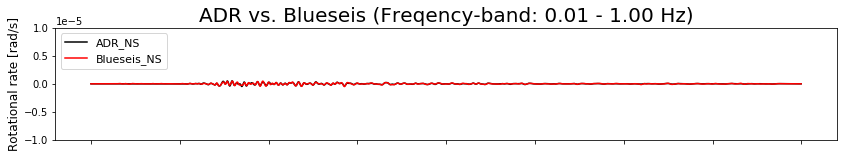

In [7]:
plt.figure(figsize=(14,7))
ax1=plt.subplot(3, 1, 1)
plt.plot(rots[1].times(),rots[1].data,'k',label='ADR_NS')
plt.plot(rots[1].times(),st_ro.select(channel="HJN")[0].data,'r',label='Blueseis_NS')
#plt.xlim(300/df,1200/df)
plt.ylim(-1.e-5,1.e-5)
#plt.ylim(-2.e-6,2.e-6)
ax1.yaxis.major.formatter.set_powerlimits((-1,2))
plt.ylabel('Rotational rate [rad/s]',fontsize=12)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend(loc=2,prop={"size":11})
plt.title('ADR vs. Blueseis (Freqency-band: %1.2f - %1.2f Hz)'%(freq_low,freq_high),fontsize=20)

Text(0.5, 1.0, 'ADR vs. Blueseis (Freqency-band: 0.01 - 1.00 Hz)')

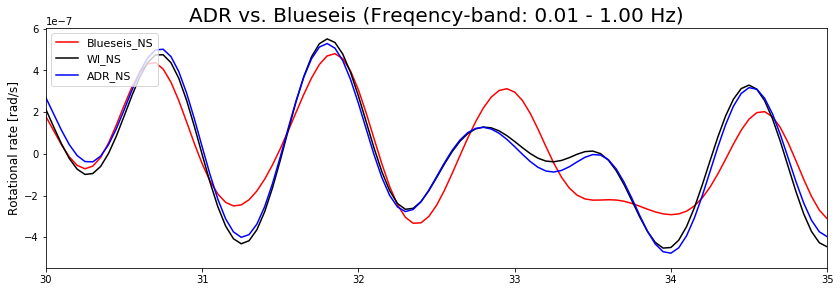

In [8]:
plt.figure(figsize=(14,15))
ax1=plt.subplot(3, 1, 1)

plt.plot(rots[1].times(),st_ro_WI.select(channel="HJN")[0].data,'r',label='Blueseis_NS')
plt.plot(WI[1].times(),WI[1].data,'k',label='WI_NS')
plt.plot(rots[1].times(),rots[1].data,'b',label='ADR_NS')

#plt.xlim(300/df,1200/df)
#plt.ylim(-1.e-5,1.e-5)
plt.xlim(30,35)
ax1.yaxis.major.formatter.set_powerlimits((-1,2))
plt.ylabel('Rotational rate [rad/s]',fontsize=12)
plt.setp(ax1.get_xticklabels(), visible=True)
plt.legend(loc=2,prop={"size":11})
plt.title('ADR vs. Blueseis (Freqency-band: %1.2f - %1.2f Hz)'%(freq_low,freq_high),fontsize=20)

*******Correlations*********
[ 0.91564775]
[ 0.91645828]
*******Misfit*********
0.405049946359
0.402270335448
******WithHilbertTransformation************
5.17732272331e-12
5.39058446738e-12
*******Maximum Value*********
4.80534061881e-07
5.515732976e-07
5.29386381242e-07
********Amp Difference********
-7.10392357187e-08
-4.88523193609e-08


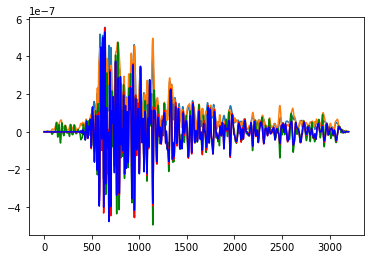

In [9]:
from obspy.signal.cross_correlation import correlate
from scipy.signal import hilbert

Cor_X_WI = correlate(WI[1].data, st_ro.select(channel="HJN")[0].data,  0)
Cor_X_Spud = correlate(rots[1].data, st_ro.select(channel="HJN")[0].data,  0)
print('*******Correlations*********')
print(Cor_X_WI)
print(Cor_X_Spud)


print('*******Misfit*********')
#tol = 1e-4
#Transformed_Components_WI_Rotation[abs(Transformed_Components_WI_Rotation) < tol] = 0.0
#Transformed_Components_Rotation[abs(Transformed_Components_WI_Rotation) < tol] = 0.0
#Transformed_Components_Spud_Rotation[abs(Transformed_Components_WI_Rotation) < tol] = 0.0
trial1 = np.sqrt(np.sum((st_ro.select(channel="HJN")[0].data - WI[1].data)**2)/np.sum((st_ro.select(channel="HJN")[0].data)**2))
print(trial1)
trial2 = np.sqrt(np.sum((st_ro.select(channel="HJN")[0].data - rots[1].data)**2)/np.sum((st_ro.select(channel="HJN")[0].data)**2))
print(trial2)

print('******WithHilbertTransformation************')
WI_ata_hil = hilbert(WI[1].data)
WI_ata_hil = np.abs(WI_ata_hil)
st_ro_data_hil = hilbert(st_ro.select(channel="HJN")[0].data)
st_ro_data_hil = np.abs(st_ro_data_hil)
spud_data_hil = hilbert(rots[1].data)
spud_data_hil = np.abs(spud_data_hil)
plt.plot(WI_ata_hil)
plt.plot(st_ro_data_hil)
#plt.plot(spud_data_hil)
misfitWithHilWI = np.sum((st_ro_data_hil - WI_ata_hil)**2)
misfitWithHilSpud = np.sum((spud_data_hil - st_ro_data_hil)**2)
print(misfitWithHilWI)
print(misfitWithHilSpud)
print('*******Maximum Value*********')
print(max(st_ro.select(channel="HJN")[0].data))
print(max(WI[1].data))
print(max(rots[1].data))
print('********Amp Difference********')
print(max(st_ro.select(channel="HJN")[0].data) - max(WI[1].data))
print(max(st_ro.select(channel="HJN")[0].data) - max(rots[1].data))

plt.plot(st_ro.select(channel="HJN")[0].data, color='g')
plt.plot(WI[1].data ,color='r')
plt.plot(rots[1].data, color='b')